In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
import itertools
from adjustText import adjust_text
import json

## Loading data

In [2]:
rsa = pd.read_csv('../../data/results/rsa.csv')

with open('../../data/embed_to_dtype.json', 'r') as f:
    embed_to_dtype = json.load(f)
    
rsa['dtype_i'] = rsa['name_i'].map(embed_to_dtype)
rsa['dtype_j'] = rsa['name_j'].map(embed_to_dtype)

rsa

,name_i,name_j,spearman,n_words,dtype_i,dtype_j
0,CBOW_GoogleNews,fastText_CommonCrawl,0.631768,42682,text,text
1,CBOW_GoogleNews,fastText_Wiki_News,0.538963,42258,text,text
2,CBOW_GoogleNews,fastTextSub_OpenSub,0.461915,40062,text,text
3,CBOW_GoogleNews,GloVe_CommonCrawl,0.499668,42660,text,text
4,CBOW_GoogleNews,GloVe_Twitter,0.219574,32663,text,text
...,...,...,...,...,...,...
320,EEG_text,fMRI_text_hyper_align,0.194555,537,brain,brain
321,EEG_text,eye_tracking,0.097018,3355,brain,brain
322,fMRI_speech_hyper_align,fMRI_text_hyper_align,0.208698,315,brain,brain
323,fMRI_speech_hyper_align,eye_tracking,0.023719,501,brain,brain


## Descriptive stats

**Within vs between dtype correlations**

In [3]:
def dtype_corr(dtype_i, dtype_j):
    corrs =  rsa.query(
        '(dtype_i == @dtype_i & dtype_j == @dtype_j) | (dtype_i == @dtype_j & dtype_j == @dtype_i)'
    )['spearman']
    return corrs.mean().round(2)

# Self-correlation
text_text, brain_brain, behavior_behavior = dtype_corr('text', 'text'), dtype_corr('brain', 'brain'), dtype_corr('behavior', 'behavior')
print(f'text-text: {text_text}')
print(f'brain-brain: {brain_brain}')
print(f'behavior-behavior: {behavior_behavior}')
print('---------------')

# Self-another
text_brain = dtype_corr('text', 'brain')
print(f'Text-brain: {text_brain}')
text_behavior = dtype_corr('text', 'behavior')
print(f'Text-behavior: {text_behavior}')
brain_behavior = dtype_corr('brain', 'behavior')
print(f'Brain-behavior: {brain_behavior}')

text-text: 0.41
brain-brain: 0.12
behavior-behavior: 0.22
---------------
Text-brain: 0.09
Text-behavior: 0.2
Brain-behavior: 0.03


**Proportion of same dtype neighbors**

In [4]:
with open('../../data/dtype_to_embed.json', 'r') as f:
    dtype_to_embed = json.load(f)

k = 3
same_dtype_props = {}
for dtype, names in dtype_to_embed.items():
    
    same_dtype_bool = [] 
    for name in names:
        k_neighbors = (
            rsa.query(f'name_i == @name | name_j == @name').nlargest(k, 'spearman')
            [['name_i', 'name_j']].to_numpy().flatten()
        )
        same_dtype_bool += [embed_to_dtype[neighbor] == dtype for neighbor in k_neighbors if neighbor != name]

    same_dtype_props[dtype] = round(np.mean(same_dtype_bool), 2)
    
same_dtype_props

{'text': 0.97, 'brain': 0.5, 'behavior': 0.93}

## MDS

In [5]:
text_names = dtype_to_embed['text']
brain_names = dtype_to_embed['brain']
behavior_names = dtype_to_embed['behavior']

print({dtype: len(names) for dtype, names in dtype_to_embed.items()})


def to_heat_df(results, col):
    # Heat df template
    names = list(pd.concat([results['name_i'], results['name_j']]).unique()) # needed because not all models guaranteed on one column
    heat_df = pd.DataFrame(index=names, columns=names)

    # Filling with correlations
    query = '(name_i == @name_i & name_j == @name_j) | (name_i == @name_j & name_j == @name_i)'
    for name_i, name_j in list(itertools.combinations(names, 2)):
        r, *_ = results.query(query)[col]
        heat_df.loc[name_i, name_j] = r
        heat_df.loc[name_j, name_i] = r
        
        order = text_names + behavior_names + brain_names

    return heat_df.loc[order, order].astype(float)


spearmans = to_heat_df(rsa, 'spearman')
spearmans

{'text': 10, 'brain': 6, 'behavior': 10}


,CBOW_GoogleNews,fastText_CommonCrawl,fastText_Wiki_News,fastTextSub_OpenSub,GloVe_CommonCrawl,GloVe_Twitter,GloVe_Wikipedia,LexVec_CommonCrawl,morphoNLM,spherical_text_Wikipedia,...,feature_overlap,norms_sensorimotor,compo_attribs,SVD_sim_rel,microarray,EEG_speech,EEG_text,fMRI_speech_hyper_align,fMRI_text_hyper_align,eye_tracking
CBOW_GoogleNews,NaN,0.631768,0.538963,0.461915,0.499668,0.219574,0.456652,0.498118,0.258314,0.439314,...,0.404074,0.072571,0.299421,0.016124,0.102466,0.055030,0.026408,0.092578,0.089944,0.051538
fastText_CommonCrawl,0.631768,NaN,0.636010,0.504868,0.617937,0.283387,0.451109,0.573953,0.274764,0.449401,...,0.451511,0.104257,0.327320,0.017493,0.072707,0.057026,0.040757,0.092032,0.084546,0.064600
fastText_Wiki_News,0.538963,0.636010,NaN,0.403008,0.519512,0.285297,0.337634,0.391567,0.256870,0.512698,...,0.398742,0.090546,0.280247,0.017061,0.121782,0.083655,0.050267,0.099324,0.124008,0.105981
fastTextSub_OpenSub,0.461915,0.504868,0.403008,NaN,0.419055,0.247239,0.346401,0.428630,0.294002,0.384523,...,0.424574,0.153438,0.349804,0.015131,0.061590,0.052906,0.033202,0.066169,0.077651,0.038228
GloVe_CommonCrawl,0.499668,0.617937,0.519512,0.419055,NaN,0.463426,0.596945,0.667117,0.371129,0.509796,...,0.406886,0.117890,0.377759,0.015297,0.177200,0.101981,0.064198,0.133940,0.160130,0.144123
GloVe_Twitter,0.219574,0.283387,0.285297,0.247239,0.463426,NaN,0.368464,0.346223,0.223618,0.264345,...,0.226574,0.109032,0.262977,0.013462,0.244243,0.117389,0.082213,0.167060,0.208462,0.122550
GloVe_Wikipedia,0.456652,0.451109,0.337634,0.346401,0.596945,0.368464,NaN,0.492453,0.308442,0.362694,...,0.356883,0.034187,0.336125,0.013611,0.197752,0.102164,0.086230,0.161345,0.189002,0.113139
LexVec_CommonCrawl,0.498118,0.573953,0.391567,0.428630,0.667117,0.346223,0.492453,NaN,0.309231,0.371618,...,0.427921,0.148660,0.370547,0.014254,0.108268,0.064237,0.050733,0.103639,0.117088,0.090223
morphoNLM,0.258314,0.274764,0.256870,0.294002,0.371129,0.223618,0.308442,0.309231,NaN,0.321685,...,0.262597,0.106807,0.324353,0.014761,-0.016557,-0.022320,-0.010426,0.003058,-0.024036,0.043238
spherical_text_Wikipedia,0.439314,0.449401,0.512698,0.384523,0.509796,0.264345,0.362694,0.371618,0.321685,NaN,...,0.377174,0.116975,0.341449,0.016945,0.134869,0.092971,0.090272,0.118898,0.154012,0.077191


In [6]:
dissimilarity = 1 - spearmans
np.fill_diagonal(dissimilarity.values, 0.0)

# MDS
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=0)
spearmans_2d = mds.fit_transform(dissimilarity)
spearmans_2d = pd.DataFrame(spearmans_2d, index=spearmans.index)

def data_type(mod_name):
    if mod_name in brain_names:
        return 'brain'
    elif mod_name in behavior_names:
        return 'behavior'
    else:
        return 'text'

# Adding data type
spearmans_2d['embed_type'] = [data_type(name) for name in spearmans_2d.index]
spearmans_2d

/Users/zhussain/opt/anaconda3/envs/psychProbingEnv/lib/python3.10/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


,0,1,embed_type
CBOW_GoogleNews,0.246541,-0.338820,text
fastText_CommonCrawl,0.163881,-0.233169,text
fastText_Wiki_News,0.158332,-0.439563,text
fastTextSub_OpenSub,0.377954,-0.231186,text
GloVe_CommonCrawl,-0.014861,-0.199785,text
GloVe_Twitter,-0.301879,0.030867,text
GloVe_Wikipedia,-0.165485,-0.222137,text
LexVec_CommonCrawl,0.012141,-0.037988,text
morphoNLM,0.223563,-0.628497,text
spherical_text_Wikipedia,-0.006129,-0.452018,text


## Plotting

In [10]:
# renaming 'compo_attribs' to 'experiential_attributes'
rename = {'compo_attribs': 'experiential_attributes', 'SVD_sim_rel': 'SVD_similarity_relatedness'}

for df in [spearmans, spearmans_2d]:
    df.index = df.index.to_series().replace(rename).values
    
# Colors
cmap = plt.get_cmap('viridis', 4)
embed_type_to_color = {
    'brain': cmap(1),
    'behavior': cmap(0),
    'text': cmap(2)
}


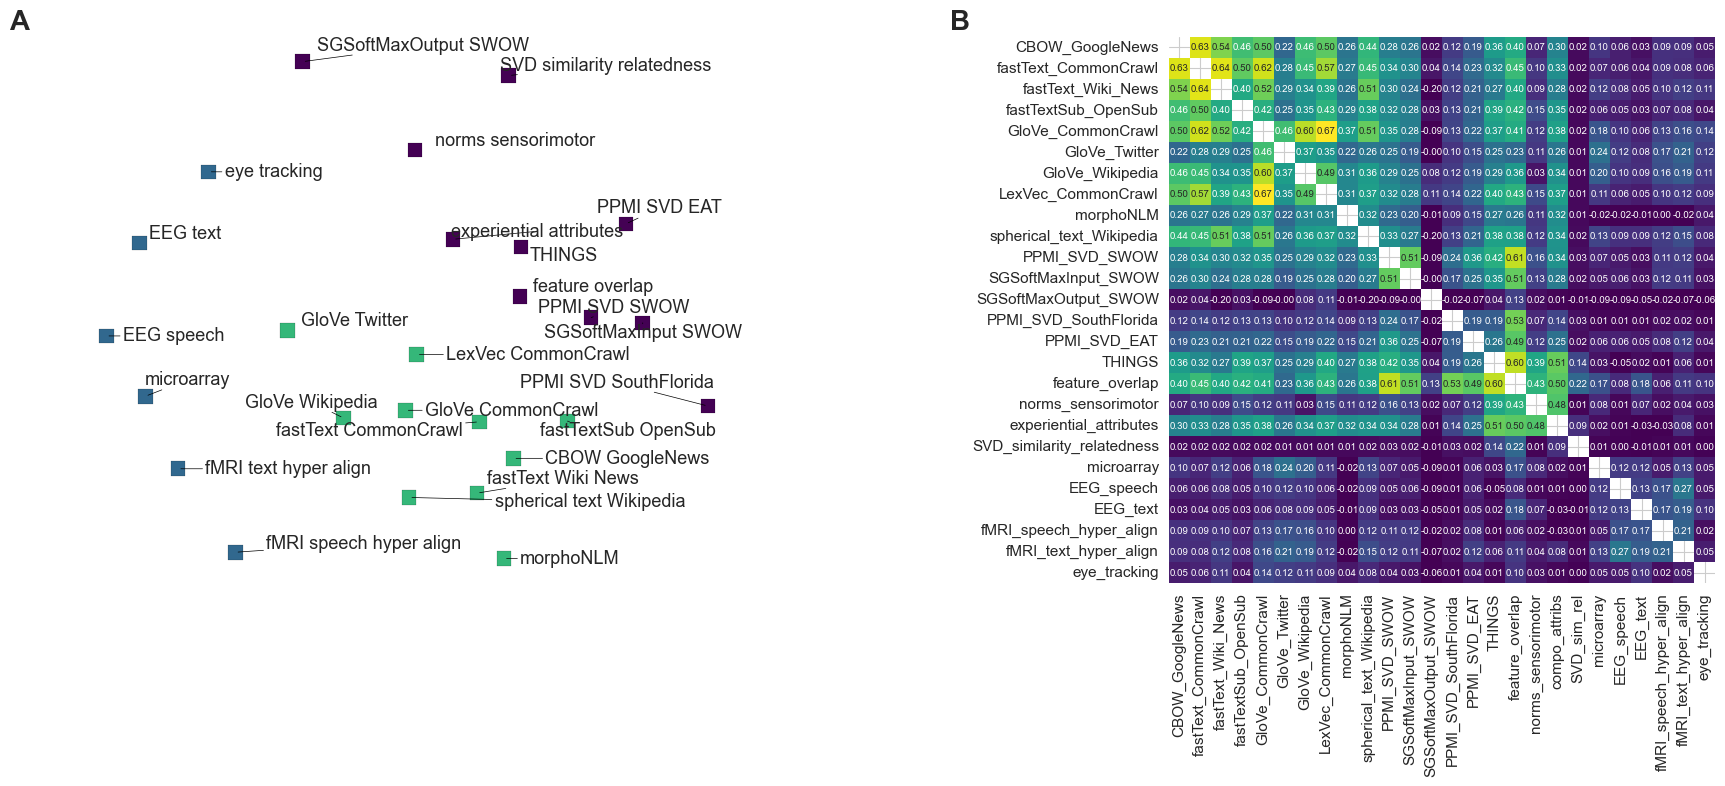

In [26]:
def plot_scatter_panel(ax, spearmans_2d, embed_type_to_color, spearmans, add_label=False):
    sns.scatterplot(
        data=spearmans_2d, x=0, y=1, hue='embed_type',
        sizes=(500, 500), legend=False, s=110,
        marker='s', linewidth=0.1, edgecolor='black',
        palette=embed_type_to_color, ax=ax
    )

    # Remove axis labels/ticks
    ax.set(xticklabels='', yticklabels='', xlabel='', ylabel='')

    # Add text labels for points
    texts = []
    for model in spearmans.index:
        texts.append(
            ax.text(
                spearmans_2d[0][model],
                spearmans_2d[1][model],
                model.replace('_', ' '),
                fontsize=13
            )
        )
    adjust_text(
        texts, arrowprops=dict(arrowstyle='-', color='black', lw=.5), ax=ax
    )

    ax.axis('off')
    
    # Optionally add the panel label
    if add_label:
        ax.text(
            -0.1, 1.05, 'A',
            transform=ax.transAxes,
            fontsize=20,
            fontweight='bold',
            va='top'
        )


def plot_heatmap_panel(ax, spearmans, add_label=False):
    """
    Draws the heatmap on the given Axes object `ax`.
    If add_label is True, draw the bold panel label 'B' on the panel.
    """
    if add_label:
        annot_fontsize = 7
        ticklabel_fontsize = 11
    else:
        annot_fontsize = 5
        ticklabel_fontsize = 9
    
    sns.heatmap(
        spearmans, square=True, annot=True, cmap='viridis',
        vmin=0, vmax=spearmans.max().max(), 
        fmt='.2f', annot_kws={"fontsize": annot_fontsize}, cbar=False, ax=ax
    )

    # Increase font size of x and y tick labels
    ax.tick_params(axis='both', which='major', labelsize=ticklabel_fontsize)

    # Optionally add the panel label
    if add_label:
        ax.text(
            -0.4, 1.05, 'B',
            transform=ax.transAxes,
            fontsize=20,
            fontweight='bold',
            va='top'
        )


# Create a 1-row, 2-column figure
fig, (ax_1, ax_2) = plt.subplots(1, 2, figsize=(20, 8), width_ratios=(0.6, 1))

# Plot each panel, adding the labels:
plot_scatter_panel(ax_1, spearmans_2d, embed_type_to_color, spearmans, add_label=True)
plot_heatmap_panel(ax_2, spearmans, add_label=True)

fig.tight_layout()
plt.savefig('../../figures/rsa.png', dpi=300, bbox_inches='tight')
plt.show()

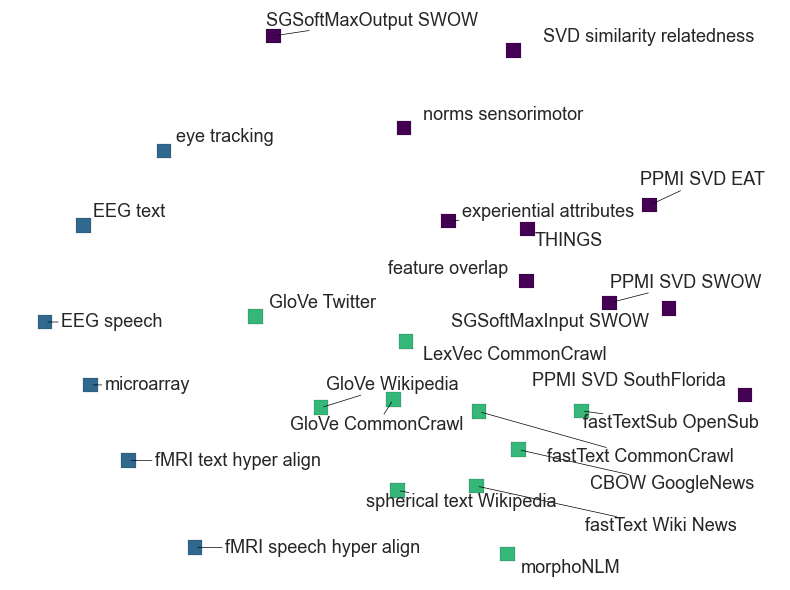

In [22]:
# MDS plot
fig_a, ax_a = plt.subplots(figsize=(8, 6))
plot_scatter_panel(ax_a, spearmans_2d, embed_type_to_color, spearmans, add_label=False)
fig_a.tight_layout()
plt.savefig('../../figures/rsa_mds.png', dpi=300, bbox_inches='tight')
plt.show()

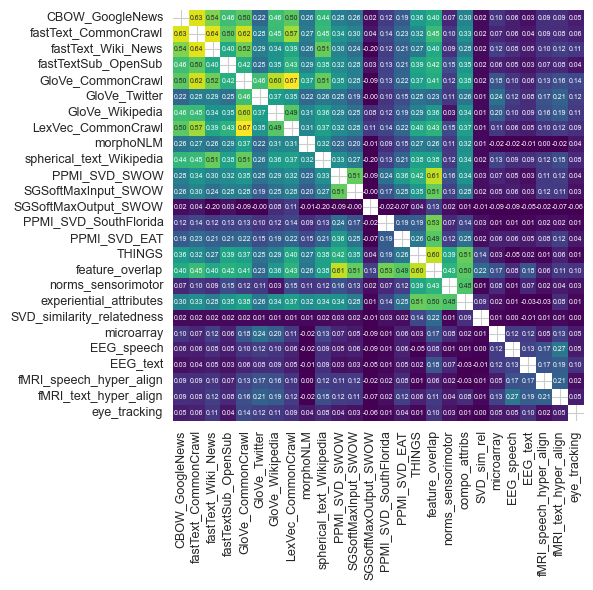

In [27]:
# rsa matrix
fig_b, ax_b = plt.subplots(figsize=(8, 6))
plot_heatmap_panel(ax_b, spearmans, add_label=False)
fig_b.tight_layout()
plt.savefig('../../figures/rsa_mat.png', dpi=300, bbox_inches='tight')
plt.show()